# Develop a Neural Bag-of-Words Model for Sentiment Analysis
Movie reviews can be classified as either favorable or not. The evaluation of movie review text is a classification problem often called sentiment analysis. A popular technique for developing sentiment analysis models is to use a bag-of-words model that transforms documents into vectors where each word in the document is assigned a score. In this workshop, you will learn how you can develop a deep learning predictive model using the bag-of-words representation for movie review sentiment classification. After completing this tutorial, you will know:
- How to prepare the review text data for modeling with a restricted vocabulary.
- How to use the bag-of-words model to prepare train and test data.
- How to develop a Multilayer Perceptron bag-of-words model and use it to make predictions on new review text data.

## Movie Review Dataset
In this workshop, we will use the Movie Review Dataset. You can download the dataset from here:
- Movie Review Polarity Dataset (`review_polarity.tar.gz`, 3MB)
http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz

After unzipping the file, you will have a directory called `txt_sentoken` with two subdirectories containing the text neg and pos or negative and positive reviews. Reviews are stored one per file with a naming convention `cv000` to `cv999` for each of neg and pos.

Please ensure that the txt_sentoken directory is in the same directory as this jupyter notebook, otherwise you will have to change the filenames.

## Data Preparation
we will look at 3 things:
- Separation of data into training and test sets.
- Loading and cleaning the data to remove punctuation and numbers.
- Defining a vocabulary of preferred words.

### Split into Train and TestSets
We are developing a system that can predict the sentiment of a textual movie review as either positive or negative. This means that after the model is developed, we will need to make predictions on new textual reviews. This will require all of the same data preparation to be performed on those new reviews as is performed on the training data for the model.

We will ensure that this constraint is built into the evaluation of our models by splitting the main data set to training and test sets prior to any data preparation. This means that any knowledge in the test set that could help us better prepare the data (e.g. the words used) is unavailable during the preparation of data and the training of the model. That being said, we will use the last 100 positive reviews and the last 100 negative reviews as a test set and the remaining 1,800 reviews as the training dataset. This is a 90% train, 10% split of the data. The split can be imposed easily by using the filenames of the reviews where reviews named 000 to 899 are for training data and reviews named 900 onwards are for testing the model.
### Loading and Cleaning Reviews
we will prepare the data using the following steps:
- Split tokens using white space.
- Remove all punctuation from words.
- Remove all words that are not purely comprised of alphabetical characters.
- Remove all words that are stop words.
- Remove all words that have a length ≤ 1 character.

We can put all of these steps into a function called `clean_doc()` that takes as an argument the raw text loaded from a file and returns a list of cleaned tokens. We can also define a function `load_doc()` that loads a document from file ready for use with the `clean_doc()` function. An example of cleaning the first positive review is below.

In [1]:
import nltk
nltk.download('stopwords')
%reset -f

[nltk_data] Downloading package stopwords to C:\Users\billy
[nltk_data]     huang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from nltk.corpus import stopwords
import string
import re

In [3]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [9]:
# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile(f"[{re.escape(string.punctuation)}]")
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

In [10]:
# load the document
filename = 'txt_sentoken/pos/cv000_29590.txt'
text = load_doc(filename)
tokens = clean_doc(text)
print(tokens)

re.compile('[!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~]')
['films', 'adapted', 'from', 'comic', 'books']
['films', 'adapted', 'comic', 'books', 'plenty', 'success', 'whether', 'theyre', 'superheroes', 'batman', 'superman', 'spawn', 'geared', 'toward', 'kids', 'casper', 'arthouse', 'crowd', 'ghost', 'world', 'theres', 'never', 'really', 'comic', 'book', 'like', 'hell', 'starters', 'created', 'alan', 'moore', 'eddie', 'campbell', 'brought', 'medium', 'whole', 'new', 'level', 'mid', 'series', 'called', 'watchmen', 'say', 'moore', 'campbell', 'thoroughly', 'researched', 'subject', 'jack', 'ripper', 'would', 'like', 'saying', 'michael', 'jackson', 'starting', 'look', 'little', 'odd', 'book', 'graphic', 'novel', 'pages', 'long', 'includes', 'nearly', 'consist', 'nothing', 'footnotes', 'words', 'dont', 'dismiss', 'film', 'source', 'get', 'past', 'whole', 'comic', 'book', 'thing', 'might', 'find', 'another', 'stumbling', 'block', 'hells', 'directors', 'albert', 'al

The complete example can be found in `1_clean_review.py`.

### Define a Vocabulary
It is important to define a vocabulary of known words when using a bag-of-words model. The more words,the larger the representation of documents,therefore it is important to constrain the words to only those believed to be predictive. This is difficult to know beforehand and often it is important to test different hypotheses about how to construct a useful vocabulary. We can develop a vocabulary as a `Counter`, which is a dictionary mapping of words and their count that allows us to easily update and query. Each document can be added to the counter (a new function called `add_doc_to_vocab()`) and we can step over all of the reviews in the negative directory and then the positive directory (a new function called `process_docs()`). The complete example is:

In [6]:
from os import listdir
from collections import Counter

In [7]:
# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
    # load doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # update counts
    vocab.update(tokens)

In [8]:
# load all docs in a directory
def process_docs(directory, vocab):
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # add doc to vocab
        add_doc_to_vocab(path, vocab)

In [9]:
# define vocab
vocab = Counter()
# add all docs to vocab
process_docs('txt_sentoken/pos', vocab)
process_docs('txt_sentoken/neg', vocab)

In [10]:
# print the size of the vocab
print(len(vocab))

44276


In [11]:
# print the top words in the vocab
print(vocab.most_common(50))

[('film', 7983), ('one', 4946), ('movie', 4826), ('like', 3201), ('even', 2262), ('good', 2080), ('time', 2041), ('story', 1907), ('films', 1873), ('would', 1844), ('much', 1824), ('also', 1757), ('characters', 1735), ('get', 1724), ('character', 1703), ('two', 1643), ('first', 1588), ('see', 1557), ('way', 1515), ('well', 1511), ('make', 1418), ('really', 1407), ('little', 1351), ('life', 1334), ('plot', 1288), ('people', 1269), ('could', 1248), ('bad', 1248), ('scene', 1241), ('movies', 1238), ('never', 1201), ('best', 1179), ('new', 1140), ('scenes', 1135), ('man', 1131), ('many', 1130), ('doesnt', 1118), ('know', 1092), ('dont', 1086), ('hes', 1024), ('great', 1014), ('another', 992), ('action', 985), ('love', 977), ('us', 967), ('go', 952), ('director', 948), ('end', 946), ('something', 945), ('still', 936)]


Running the example shows that we have a vocabulary of 44,276 words. We also can see a sample of the top 50 most used words in the movie reviews. Note that this vocabulary was constructed based on only those reviews in the training dataset.

The complete example can be found in `2_select_vocab.py`.

We can step through the vocabulary and remove all words that have a low occurrence, such as only being used once or twice in all reviews. For example, the following snippet will retrieve only the tokens that appear 2 or more times in all reviews.

In [12]:
min_occurrence = 2
tokens = [k for k, c in vocab.items() if c >= min_occurrence]
print(len(tokens))

25767


Running the above example with this addition shows that the vocabulary size drops by a little more than half its size, from about 44,000 to about 25,000 words.

Finally, the vocabulary can be saved to a new file called `vocab.txt` that we can later load and use to filter movie reviews prior to encoding them for modeling. We define a new function called save_list() that saves the vocabulary to file, with one word per line. For example:

In [13]:
# save list to file
def save_list(lines, filename):
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w')
    # write text
    file.write(data)
    # close file
    file.close()

In [14]:
# save tokens to a vocabulary file
save_list(tokens, 'vocab.txt')

Running the min occurrence filter on the vocabulary and saving it to file, you should now have a new file called `vocab.txt` with only the words we are interested in.

In [15]:
N_WORDS_TO_PRINT = 10
print(f"Printing the first {N_WORDS_TO_PRINT} words from the vocab.txt file:")
with open('vocab.txt') as f:
    for i in range(N_WORDS_TO_PRINT):
        print(f"    {f.readline()}", end='')

Printing the first 10 words from the vocab.txt file:
    films
    adapted
    comic
    books
    plenty
    success
    whether
    theyre
    superheroes
    batman


The complete example can be found in `3_filter_vocab.py`.

We are now ready to look at extracting features from the reviews ready for modeling.

## Bag-of-Words Representation
Here we will look at how we can convert each review into a representation that we can provide to a Multilayer Perceptron model. A bag-of-words model is a way of extracting features from text so the text input can be used with machine learning algorithms like neural networks. Each document, in this case a review, is converted into a vector representation. The number of items in the vector representing a document corresponds to the number of words in the vocabulary. The larger the vocabulary, the longer the vector representation, hence the preference for smaller vocabularies in the previous section.

Words in a document are scored and the scores are placed in the corresponding location in the representation. We will look at different word scoring methods in the next section. In this section, we are concerned with converting reviews into vectors ready for training a first neural network model. This section is divided into 2 steps:

- Converting reviews to lines of tokens.
- Encoding reviews with a bag-of-words model representation.

### Reviews to Lines of Tokens
Before we can convert reviews to vectors for modeling, we must first clean them up. This involves loading them, performing the cleaning operation developed above,filtering out words not in the chosen vocabulary, and converting the remaining tokens into a single string or ready for encoding. First, we need a function to prepare one document. Below is the function `doc_to_line()` that will load a document, clean it, filter out tokens not in the vocabulary, then return the document as a string of white space separated tokens.

In [16]:
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
    # load the doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

Next, we need a function to work through all documents in a directory (such as `pos` and `neg`) to convert the documents into lines. Below lists the `process_docs()` function that does just this, expecting a directory name and a vocabulary set as input arguments and returning a list of processed documents.

In [17]:
# load all docs in a directory
def process_docs(directory, vocab):
    lines = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load and clean the doc
        line = doc_to_line(path, vocab)
        # add to list
        lines.append(line)
    return lines

We can call the `process_docs()` consistently for positive and negative reviews to construct a dataset of review text and their associated output labels, 0 for negative and 1 for positive. The `load_clean_data()` function below implements this behavior.

In [18]:
# load and clean a dataset
def load_clean_dataset(vocab):
    # load documents
    neg = process_docs('txt_sentoken/neg', vocab)
    pos = process_docs('txt_sentoken/pos', vocab)
    docs = neg + pos
    # prepare labels
    labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
    return docs, labels

Finally, we need to load the vocabulary and turn it into a set for use in cleaning reviews.

In [19]:
# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)
# load all training reviews
docs, labels = load_clean_dataset(vocab)

Running this example loads and cleans the review text and returns the labels.

In [20]:
# summarize what we have
print(len(docs), len(labels))

1800 1800


The complete example can be found in `4_filter_all_reviews.py`

### Movie Reviews to Bat-of-Words Vectors
We will use the Keras API to convert reviews to encoded document vectors. Keras provides the `Tokenizer` class that can do some of the cleaning and vocab definition tasks that we took care of in the previous section. The `Tokenizer` class is convenient and will easily transform documents into encoded vectors. First, the `Tokenizer` must be created, then fit on the text documents in the training dataset. In this case, these are the aggregation of the positive lines and negative lines arrays.

In [21]:
from keras.preprocessing.text import Tokenizer
from numpy import array

In [22]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

This process determines a consistent way to convert the vocabulary to a fixed-length vector with 25,768 elements, which is the total number of words in the vocabulary file `vocab.txt`.

Next, documents are encoded using the `Tokenizer` by calling `text_to_matrix()`. The function takes both a list of documents to encode and an encoding mode, which is the method used to score words in the document. Here we specify `freq` to score words based on their frequency in the document. This can be used to encode the loaded training and test data, for example:

In [23]:
tokenizer = create_tokenizer(docs)
# encode data
Xtrain = tokenizer.texts_to_matrix(docs, mode='freq')

This encodes all of the positive and negative reviews in the training dataset. Next, the `process_doc()` function from the previous section needs to be modified to selectively process reviews in the test or train dataset. We support the loading of both the training and test datasets by adding an `is_train` argument and using that to decide what review file names to skip. By adding a default value to `is_train` we ensure backwards compatibility.

In [24]:
# load all docs in a directory
def process_docs(directory, vocab, is_train=True):
    lines = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if is_train and filename.startswith('cv9'):
            continue
        if not is_train and not filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load and clean the doc
        line = doc_to_line(path, vocab)
        # add to list
        lines.append(line)
    return lines

Similarly, the `load_clean_dataset()` dataset must be updated to load either train or test data and ensure it returns a NumPy array.

In [25]:
def load_clean_dataset(vocab, is_train=True):
    # load documents
    neg = process_docs('txt_sentoken/neg', vocab, is_train)
    pos = process_docs('txt_sentoken/pos', vocab, is_train)
    docs = neg + pos
    # prepare labels
    labels = array([0 for _ in range(len(neg))] + [1 for _ in range(len(pos))])
    return docs, labels

Running the example prints both the shape of the encoded training dataset and test dataset with 1,800 and 200 documents respectively, each with the same sized encoding vocabulary (vector length).

In [26]:
# load all reviews
train_docs, ytrain = load_clean_dataset(vocab, True)
test_docs, ytest = load_clean_dataset(vocab, False)
# create the tokenizer
tokenizer = create_tokenizer(train_docs)
# encode data
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='freq')
Xtest = tokenizer.texts_to_matrix(test_docs, mode='freq')

In [27]:
print(Xtrain.shape, Xtest.shape)

(1800, 25768) (200, 25768)


The complete example can be found in `5_prepare_data.py`

## Sentiment Analysis Models
In this section, we will develop Multilayer Perceptron (MLP) models to classify encoded documents as either positive or negative. The models will be simple feed forward network models with fully connected layers called `Dense` in the Keras deep learning library.
### First Sentiment Analysis Model
We can develop a simple MLP model to predict the sentiment of encoded reviews. The model will have an input layer that equals to the number of words in the vocabulary, and in turn the length of the input documents. We can store this in a new variable called `n_words`, as follows:

In [28]:
n_words = Xtest.shape[1]

We can now define the network. We will use a single hidden layer with 50 neurons and a rectified linear activation function. The output layer is a single neuron with a sigmoid activation function for predicting 0 for negative and 1 for positive reviews. The network will be trained using Adam implementation of gradient descent and the binary cross-entropy loss function, suited to binary classification problems. We will keep track of accuracy when training and evaluating the model.

In [29]:
from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense

In [30]:
# define the model
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(50, input_shape=(n_words, ), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

When defining the model, the summary of the model is printed and a plot is saved with the name `model.png`

In [31]:
# define the model
model = define_model(n_words)
# summarize defined model
model.summary()
# If you get an error on the following line, you might neet to install Graphviz.
# You could alternatively just comment it out and not generate 'model.png'.
plot_model(model, to_file='model.png', show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                1288450   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 1,288,501
Trainable params: 1,288,501
Non-trainable params: 0
_________________________________________________________________
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


Next, we fit the model on the training data; in this case, the model is small and is easily fit in 10 epochs.

In [32]:
# fit network
model.fit(Xtrain, ytrain, epochs=10, verbose=2)

Epoch 1/10
57/57 - 0s - loss: 0.6920 - accuracy: 0.5717
Epoch 2/10
57/57 - 0s - loss: 0.6842 - accuracy: 0.7767
Epoch 3/10
57/57 - 0s - loss: 0.6693 - accuracy: 0.8989
Epoch 4/10
57/57 - 0s - loss: 0.6457 - accuracy: 0.8894
Epoch 5/10
57/57 - 0s - loss: 0.6150 - accuracy: 0.9233
Epoch 6/10
57/57 - 0s - loss: 0.5782 - accuracy: 0.9339
Epoch 7/10
57/57 - 0s - loss: 0.5382 - accuracy: 0.9433
Epoch 8/10
57/57 - 0s - loss: 0.4966 - accuracy: 0.9500
Epoch 9/10
57/57 - 0s - loss: 0.4567 - accuracy: 0.9550
Epoch 10/10
57/57 - 0s - loss: 0.4173 - accuracy: 0.9633


We can see that the model fits the training data within the 10 epochs, achieving close to 100% accuracy. 

Finally, once the model is trained, we can evaluate its performance by making predictions in the test dataset and printing the accuracy.

In [33]:
# evaluate
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print(f"Test Accuracy: {acc*100:.2f}%")

Test Accuracy: 87.50%


Evaluating the model on the test dataset, we can see that model does well, achieving an accuracy of above 87%.

The complete example can be found in `6_mlp_bow_model.py`

## Comparing Word Scoring Methods

The `text_to_matrix()` function for the `Tokenizer` in the Keras API provides 4 different methods for scoring words; they are:
- **binary** Where words are marked as present (1) or absent (0)
- **count** Where the occurrence count for each word is marked as an integer.
- **tfidf** Where each word is scored based on their frequency, where words that are common across all documents are penalized.
- **freq** Where words are scored based on their frequency of occurrence within the document.

We can evaluate the model developed in the previous section using each of the 4 supported word scoring mode. This first involves the implementation of a function to create an encoding of the loaded documents based on a chosen scoring model. The function creates the tokenizer, fits it on the training documents, then creates the train and test encodings using the chosen model. The function `prepare_data()` implements this behavior given lists of train and test documents.

In [34]:
# prepare bag of words encoding of docs
def prepare_data(train_docs, test_docs, mode):
    # create the tokenizer
    tokenizer = Tokenizer()
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
    # encode training data set
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    # encode training data set
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest

We also need a function to evaluate the MLP given a specific encoding of the data. Because neural networks are stochastic, they can produce different results when the same model is fit on the same data. This is mainly because of the random initial weights and the shuffling of patterns during minibatch gradient descent. This means that any scoring of a model is unreliable and we should estimate model performance based on an average of multiple runs. The function below, named `evaluate_mode()` takes encoded documents and evaluates the MLP by training it on the train set and estimating the performance on the test set 10 times and returns a list of the accuracy scores across all of these runs.

In [35]:
# evaluate a neural network model
def evaluate_mode(Xtrain, ytrain, Xtest, ytest):
    scores = list()
    n_repeats = 4
    n_words = Xtest.shape[1]
    for i in range(n_repeats):
        # define network
        model = define_model(n_words)
        # fit network
        model.fit(Xtrain, ytrain, epochs=10, verbose=0)
        # evaluate
        _, acc = model.evaluate(Xtest, ytest, verbose=0)
        scores.append(acc)
        print(f"{i+1} accuracy: {acc}")
    return scores

We are now ready to evaluate the performance of the 4 different word scoring methods.

In [36]:
from pandas import DataFrame
from matplotlib import pyplot

In [37]:
# run experiment
modes = ['binary', 'count', 'tfidf', 'freq']
results = DataFrame()
for mode in modes:
    # prepare data for mode
    Xtrain, Xtest = prepare_data(train_docs, test_docs, mode)
    # evaluate model on data for mode
    results[mode] = evaluate_mode(Xtrain, ytrain, Xtest, ytest)

1 accuracy: 0.925000011920929
2 accuracy: 0.9399999976158142
3 accuracy: 0.9350000023841858
4 accuracy: 0.9300000071525574
1 accuracy: 0.8849999904632568
2 accuracy: 0.8899999856948853
3 accuracy: 0.9100000262260437
4 accuracy: 0.8899999856948853
1 accuracy: 0.8700000047683716
2 accuracy: 0.8650000095367432
3 accuracy: 0.8849999904632568
4 accuracy: 0.8500000238418579
1 accuracy: 0.7200000286102295
2 accuracy: 0.8700000047683716
3 accuracy: 0.8650000095367432
4 accuracy: 0.8700000047683716


In [38]:
# summarize results
print(results.describe())

         binary     count     tfidf      freq
count  4.000000  4.000000  4.000000  4.000000
mean   0.932500  0.893750  0.867500  0.831250
std    0.006455  0.011087  0.014434  0.074204
min    0.925000  0.885000  0.850000  0.720000
25%    0.928750  0.888750  0.861250  0.828750
50%    0.932500  0.890000  0.867500  0.867500
75%    0.936250  0.895000  0.873750  0.870000
max    0.940000  0.910000  0.885000  0.870000


At the end of the run, summary statistics for each word scoring method are provided, summarizing the distribution of model skill scores across each of the 10 runs per mode. We can see that the mean score of both the `count` and `binary` methods appear to be better than `freq` and `tfidf`.

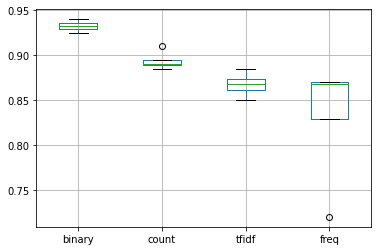

In [39]:
# plot results
results.boxplot()
pyplot.show()

A box and whisker plot of the results is also presented, summarizing the accuracy distributions
per configuration. We can see that binary achieved the best results with a modest spread and
might be the preferred approach for this dataset.

The complete example can be found in `7_compare_encodings.py`

## Predicting Sentiment for New Reviews
Finally,we can develop and use a final model to make predictions for new textual reviews. This is why we wanted the model in the first place. First, we will train a final model on all of the available data. We will use the `binary` mode for scoring the bag-of-words model that was shown to give the best results in the previous section.

Predicting the sentiment of new reviews involves following the same steps used to prepare the test data. Specifically, loading the text, cleaning the document, filtering tokens by the chosen vocabulary, converting the remaining tokens to a line, encoding it using the `Tokenizer`, and making a prediction. We can make a prediction of a class value directly with the fit model by calling `predict()` that will return 0 for a negative review and 1 for a positive review. All of these steps can be put into a new function called `predict_sentiment()` that requires the review text, the vocabulary, the tokenizer, and the fit model and returns the predicted sentiment and an associated percentage or confidence-like output.

In [40]:
# classify a review as negative or positive
def predict_sentiment(review, vocab, tokenizer, model):
    # clean
    tokens = clean_doc(review)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    # convert to line
    line = ' '.join(tokens)
    # encode
    encoded = tokenizer.texts_to_matrix([line], mode='binary')
    # predict sentiment
    yhat = model.predict(encoded, verbose=0)
    # retrieve predicted percentage and label
    percent_pos = yhat[0, 0]
    if round(percent_pos) == 0:
        return (1 - percent_pos), 'NEGATIVE'
    return percent_pos, 'POSITIVE'

We can now make predictions for new review texts. Below is an example with both a clearly positive and a clearly negative review using the simple MLP developed above with the frequency word scoring mode.

In [41]:
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='binary')
Xtest = tokenizer.texts_to_matrix(test_docs, mode='binary')
# define network
n_words = Xtrain.shape[1]
model = define_model(n_words)
# fit network
model.fit(Xtrain, ytrain, epochs=10, verbose=2)

Epoch 1/10
57/57 - 0s - loss: 0.4722 - accuracy: 0.7839
Epoch 2/10
57/57 - 0s - loss: 0.0594 - accuracy: 0.9961
Epoch 3/10
57/57 - 0s - loss: 0.0165 - accuracy: 1.0000
Epoch 4/10
57/57 - 0s - loss: 0.0078 - accuracy: 1.0000
Epoch 5/10
57/57 - 0s - loss: 0.0047 - accuracy: 1.0000
Epoch 6/10
57/57 - 0s - loss: 0.0032 - accuracy: 1.0000
Epoch 7/10
57/57 - 0s - loss: 0.0024 - accuracy: 1.0000
Epoch 8/10
57/57 - 0s - loss: 0.0018 - accuracy: 1.0000
Epoch 9/10
57/57 - 0s - loss: 0.0014 - accuracy: 1.0000
Epoch 10/10
57/57 - 0s - loss: 0.0011 - accuracy: 1.0000


In [42]:
# test positive text
text = 'Best movie ever! It was great, I recommend it.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print(f"Review: [{text}]\nSentiment: {sentiment} ({percent * 100:.3f}%)")
# test negative text
text = 'This is a bad movie.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print(f"Review: [{text}]\nSentiment: {sentiment} ({percent * 100:.3f}%)")

Review: [Best movie ever! It was great, I recommend it.]
Sentiment: POSITIVE (57.723%)
Review: [This is a bad movie.]
Sentiment: NEGATIVE (63.711%)


The complete example can be found in `8_prediction.py`